# Basic Examples showing how to work with Dual-Communities
These examples give a basic idea on how to generate dual graphs from given primal graphs and how to analyze them.

In [1]:
import numpy as np
import copy
import networkx as nx

import gzip
import pickle

import matplotlib as mpl
from matplotlib import pyplot as plt

from dual_communities import plot_functions, synthetic_leafs, hierarchy_detection, distribution_factors
from dual_communities.dual_graph import create_dual_from_graph, get_boundary_infos

## Helper
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

## Lattice

In [2]:
def assign_pos(m, n):
    pos = {}
    for i in range(m):
        for j in range(n):
            pos[i, j] = np.array([i*float(1/m), j*float(1/n)])
    return pos

In [3]:
NN_lattice, MM_lattice = (9, 4)

graph_lattice = nx.generators.grid_2d_graph(NN_lattice, MM_lattice)
nx.set_node_attributes(graph_lattice, name='pos',
                       values=assign_pos(NN_lattice, MM_lattice))

edges_primal_vein = list()
for ii in range(MM_lattice - 1):
    edges_primal_vein.append(((int(NN_lattice/2), ii), (int(NN_lattice/2), ii+1)))
    
# Strengthen central vein to create a dual communities
base_weight = 1
kk_fac = 10

ww = {xx: (base_weight*kk_fac if (xx in edges_primal_vein or xx[::-1] in edges_primal_vein) 
           else base_weight)
      for xx in graph_lattice.edges()}
nx.set_edge_attributes(graph_lattice, name='weight', values=ww)

# Create dual graph
dual_lattice = create_dual_from_graph(graph_lattice)


/home/pboettcher/Documents/git_repos/publications/dual-communities/dual_communities/dual_graph.py:126: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "get_dual_pos" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/pboettcher/Documents/git_repos/publications/dual-communities/dual_communities/dual_graph.py (130)

File "dual_communities/dual_graph.py", line 130:
def get_dual_pos(faces,pos):
    <source elided>
    
    dual_pos={}
    ^

  @jit
/home/pboettcher/Documents/git_repos/publications/dual-communities/dual_communities/dual_graph.py:126: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_dual_pos" failed type inference due to: Cannot determine Numba type of <class 'numba.core.dispatcher.LiftedLoop'>

File "dual_communities/dual_graph.py", line 132:
def get_dual_pos(faces,pos):
    <source elided>
    
    for i in range(len(faces)

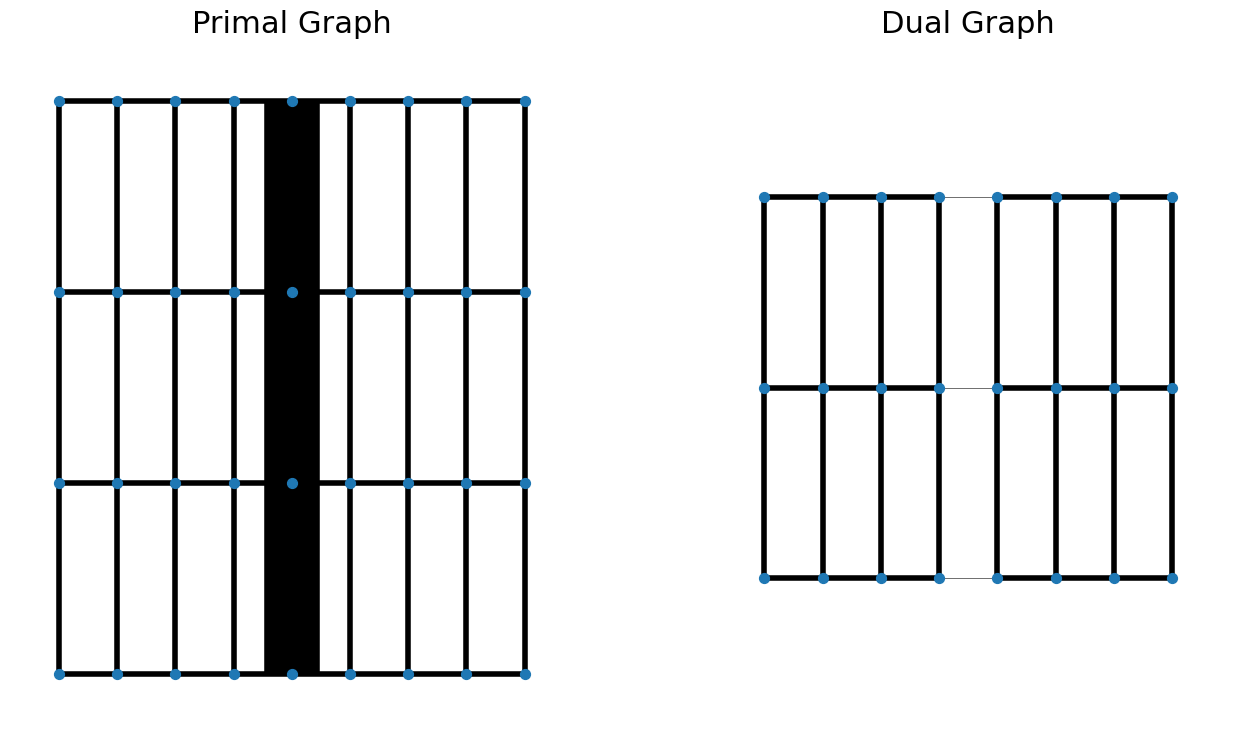

In [4]:
# Plot graph and its dual
fig, ax = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(16, 9))

primal_weights = [graph_lattice[uu][kk]['weight']*4 for uu, kk in graph_lattice.edges()]
dual_weights = [dual_lattice[uu][kk]['weight']*4 for uu, kk in dual_lattice.edges()]

draw_kwargs = dict(node_size=50)
nx.draw(graph_lattice, pos=nx.get_node_attributes(graph_lattice, 'pos'),
        ax=ax[0], width=primal_weights, **draw_kwargs)
nx.draw(dual_lattice, pos=nx.get_node_attributes(dual_lattice, 'pos'),
        ax=ax[1], width=dual_weights, **draw_kwargs)

ax[0].set_title("Primal Graph", size=22)
ax[1].set_title("Dual Graph", size=22)

plt.show()

Using median for communities
Finished level 0
Using median for communities
Using median for communities
Finished level 1


<class 'networkx.utils.decorators.argmap'> compilation 12:4: FutureWarning: laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


Text(0.5, 1.0, 'Cut level')

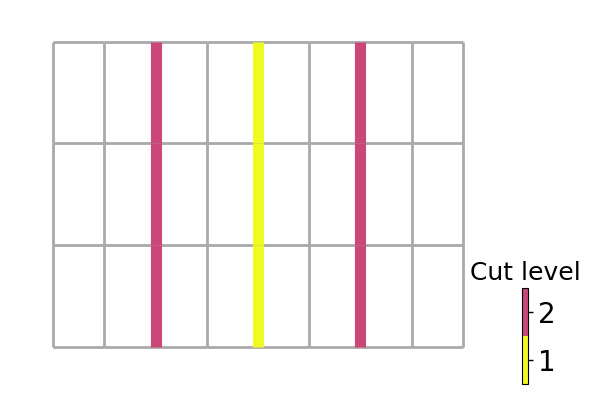

In [5]:
# Hierarchical clustering of the primal graph using the dual graph

_, _ , boundaries_lattice = hierarchy_detection.get_hierarchy_levels_dual(graph_lattice, dual_lattice, nof_levels=2, networkx_fiedler=False)
bound_dict_lattice, bound_width_lattice = get_boundary_infos(graph_lattice, boundaries_lattice, cut_lvl=2)

fig, ax = plt.subplots()
plot_functions.draw_actual_leaf(ax, graph_lattice, bound_dict_lattice, bound_width_lattice, 2, width_factor=2)
ax.axis('off')

cbar_ax = fig.add_axes([.925, 0.1, 0.01, 0.2])#
nof_levels = 2
cmap = plt.get_cmap('plasma_r')
cm = mpl.colors.ListedColormap([cmap(i/nof_levels) for i in range(nof_levels)])
cm.set_under('darkgray',1.0)
sm = plt.cm.ScalarMappable(cmap = cm) 
sm._A = []
cb = fig.colorbar(sm,cax = cbar_ax,ticks = [(i+.5)/nof_levels for i in range(nof_levels)])
cb.ax.tick_params(labelsize = 36, width = 1.0)
cb.ax.set_yticklabels([str(i+1) for i in range(nof_levels)],
                      size = 20)

cb.ax.set_title('Cut level', size=18)


/home/pboettcher/Documents/git_repos/publications/dual-communities/dual_communities/distribution_factors.py:57: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  I = nx.incidence_matrix(G,oriented=True).todense()


(-0.09333333333333332, 0.9822222222222221, -0.07875000000000001, 0.82875)

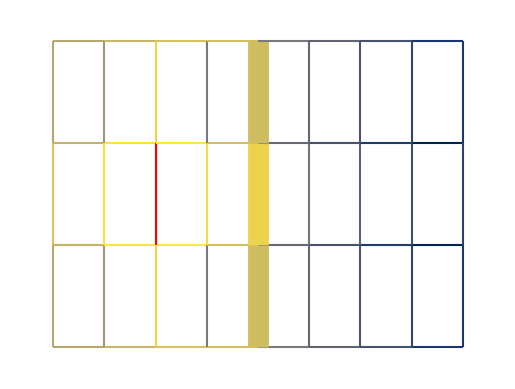

In [6]:
# Line Outage distribution factor showing the effect of the failing link (red color) to the rest of the links
error_link = ((2, 1), (2, 2))
error_link_idx = distribution_factors.redefined_index(list(graph_lattice.edges()), error_link)
lodf_matrix_row = distribution_factors.calc_LODF_matrix(graph_lattice)[:, error_link_idx]

cmap_lodf = copy.copy(plt.get_cmap('cividis'))
cmap_lodf.set_bad('r', 1.)
cmap_lodf.set_over('r', 1.)
cmap_lodf.set_under('gainsboro', 1.)

color_edges = np.array([np.log10(xx) if xx > 1e-8 else -np.inf for xx in np.abs(lodf_matrix_row)]).flatten()
color_edges[error_link_idx] = 1e5 
vmax = (np.max(color_edges[np.logical_and(np.logical_and(~np.isnan(color_edges),
                                                                  color_edges!=-float("inf")),
                                                   color_edges!=1e5)]))
vmin = (np.min(color_edges[np.logical_and(~np.isnan(color_edges),
                                                   color_edges!=-float("inf"))]))

fig, ax = plt.subplots()
width_edges = [graph_lattice[uu][kk]['weight']*1.5 for uu, kk in graph_lattice.edges()]
nx.draw_networkx_edges(graph_lattice, nx.get_node_attributes(graph_lattice, 'pos'), ax=ax,
                       edge_cmap=cmap_lodf, edge_color=color_edges, edge_vmin=vmin, edge_vmax=vmax, width=width_edges)
ax.axis('off')

## Synthetic Leafs

In [7]:
# imports
from dual_communities import synthetic_leafs

In [8]:
# Generate two synthetic leafs that exhibit a primal and dual community structure, respectively
fh_path = "example_synthetic_leafs.pklz"

if os.path.exists(fh_path):
    with gzip.open(fh_path, 'rb') as fh_syn_leaf:
        network_ls = pickle.load(fh_syn_leaf)
       
    
else:
    NN = 26
    nof_sources = 2
    KK = 500
    gamma = .9
    sigma_d_sq_ls = [3.1, 6.1*1e4]
    
    alpha_funci = lambda sigma_d_sq_r: (KK**2/(sigma_d_sq_r*nof_sources**3)*(nof_sources- 1 )) - 1/nof_sources
    
    dirichelet_par = [alpha_funci(xx) for xx in sigma_d_sq_ls]
    
    
    # Generate networks
    network_ls = list()
    for idx, dir_par_r in enumerate(dirichelet_par):
        network = synthetic_leafs.build_artificial_leaf_triangular_multisource_dirichlet(NN, gamma,
                                       nof_sources=nof_sources,
                                       dirichlet_constant=KK,
                                       dirichlet_parameter=dir_par_r,
                                       threshold=1e-9,
                                       max_repetitions=1e3,
                                       mu=-1, sigma=.1)
        network_ls.append(network)
    
    with gzip.open(fh_path, 'wb') as fh_syn_leaf:
        pickle.dump(network_ls, fh_syn_leaf)

Text(0.5, 1.0, 'Dual Communities')

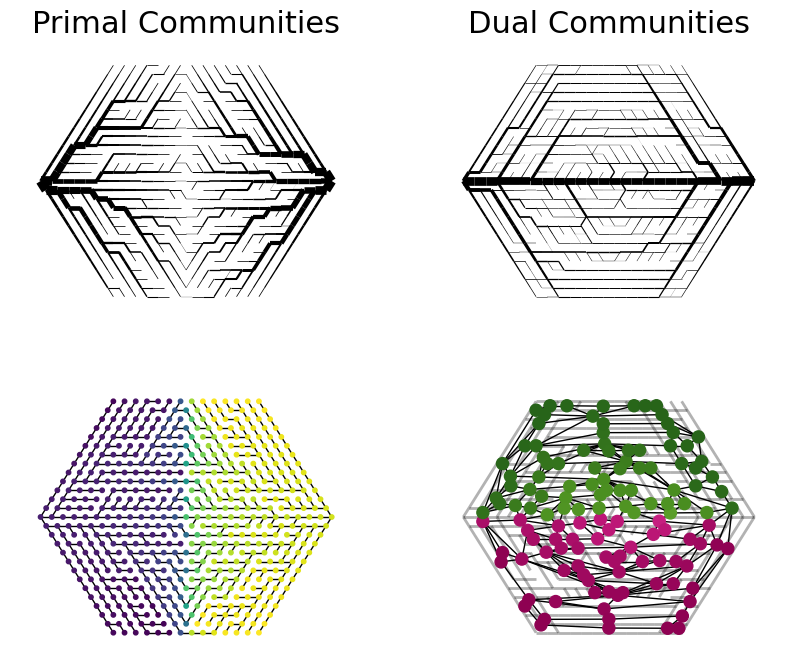

In [9]:
# The follwowing will highlight the community structure by showing the fiedler vector for both
# the graph with primal community structure and the dual of the graph with dual community structure in the left and right 
# columns, respectively.

gra_prim_com = network_ls[0].copy()
neglibalbe_edges = [xx for xx in gra_prim_com.edges() if gra_prim_com[xx[0]][xx[1]]['weight'] < 1e-8]
prim_com_fieldervec = nx.fiedler_vector(gra_prim_com)
gra_prim_com.remove_edges_from(neglibalbe_edges)

gra_dual_com = network_ls[1].copy()
neglibalbe_edges = [xx for xx in gra_dual_com.edges() if gra_dual_com[xx[0]][xx[1]]['weight'] < 1e-8]
gra_dual_com.remove_edges_from(neglibalbe_edges)

# Plot it
fig, ax = plt.subplots(2, 2,figsize=(10, 8))
caps = np.asarray([gra_prim_com[uu][kk]['weight'] for uu, kk in gra_prim_com.edges()])
nx.draw_networkx_edges(gra_prim_com, pos=nx.get_node_attributes(gra_prim_com, 'pos'),
                       width=np.sqrt(caps/caps.max())*7,
                       ax=ax[0, 0])

caps = np.asarray([gra_dual_com[uu][kk]['weight'] for uu, kk in gra_dual_com.edges()])
nx.draw_networkx_edges(gra_dual_com, pos=nx.get_node_attributes(gra_dual_com, 'pos'),
                       width=np.sqrt(caps/caps.max())*7, 
                       ax=ax[0, 1])

norm_fvec_primal = MidpointNormalize(midpoint=0, vmax=np.max(prim_com_fieldervec),
                                       vmin=np.min(prim_com_fieldervec))
nx.draw_networkx_nodes(gra_prim_com, pos=nx.get_node_attributes(gra_prim_com, 'pos'),
                       node_color=norm_fvec_primal(prim_com_fieldervec), node_size=10, ax=ax[1,0])
nx.draw_networkx_edges(gra_prim_com, pos=nx.get_node_attributes(gra_prim_com, 'pos'), ax=ax[1,0])

dual_gra = create_dual_from_graph(gra_dual_com)
dual_fiedler_vec = nx.fiedler_vector(dual_gra)

norm_fvec_dual = MidpointNormalize(midpoint=0, vmax=np.max(dual_fiedler_vec),
                                       vmin=np.min(dual_fiedler_vec))
nx.draw_networkx_edges(gra_dual_com, pos=nx.get_node_attributes(gra_dual_com, 'pos'), alpha=.3, width=2.)
nx.draw_networkx_nodes(dual_gra, pos=nx.get_node_attributes(dual_gra, 'pos'),
                       node_color=norm_fvec_dual(dual_fiedler_vec), node_size=75, ax=ax[1,1], cmap=plt.get_cmap('PiYG'))
nx.draw_networkx_edges(dual_gra, pos=nx.get_node_attributes(dual_gra, 'pos'), ax=ax[1,1])

# Aesthetics
for ax_r in ax.flatten():
    ax_r.axis('off')
ax[0,0].set_title("Primal Communities", size=22)
ax[0,1].set_title("Dual Communities", size=22)